### Import Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Load Dataset

In [2]:
# Load the dataset
df = pd.read_csv('../data/newsData/raw_analyst_ratings.csv')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print("\nColumns:")
print(df.columns.tolist())
print("\nTop Five Rows:")
print(df.head())
print("\nBasic Info:")
print(df.info())


Dataset Overview:
Shape: (1407328, 6)

Columns:
['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']

Top Five Rows:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

            

### Basic Cleaning

In [3]:
# 1. NULL VALUE HANDLING

print("\n--- 1. Null Value Check (Before Cleaning) ---")
print(df.isnull().sum())

df.dropna(subset=['headline'], inplace=True)

print("\n--- Null Value Check (After Cleaning) ---")
print(f"Remaining rows after dropping null headlines: {df.shape[0]}")

# 2. DUPLICATE AND CONSISTENCY CHECKS 

# Check for duplicate rows across all columns
duplicate_count = df.duplicated().sum()
print(f"\nTotal duplicate rows found: {duplicate_count}")

if duplicate_count > 0:
    # Drop duplicates, keeping the first instance
    df.drop_duplicates(inplace=True)
    print(f"Rows remaining after dropping duplicates: {df.shape[0]}")

# Ensure the 'headline' column is string type before analysis
df['headline'] = df['headline'].astype(str)

# 3. DATE FORMAT CONVERSION
if 'date' in df.columns:
    
    # 1. Force conversion using 'ISO8601' format and ensure UTC conversion.
    df['date'] = pd.to_datetime(df['date'], format='ISO8601', errors='coerce', utc=True)
    
    print("\n--- 2. Date Column Structure (After Conversion) ---")
    print(df['date'].head())
    print(f"Data type is now: {df['date'].dtype}") 
    
else:
    print("\nWarning: Date column not found. Skipping date conversion.")



--- 1. Null Value Check (Before Cleaning) ---
Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

--- Null Value Check (After Cleaning) ---
Remaining rows after dropping null headlines: 1407328

Total duplicate rows found: 0

--- 2. Date Column Structure (After Conversion) ---
0   2020-06-05 14:30:54+00:00
1   2020-06-03 14:45:20+00:00
2   2020-05-26 08:30:07+00:00
3   2020-05-22 16:45:06+00:00
4   2020-05-22 15:38:59+00:00
Name: date, dtype: datetime64[ns, UTC]
Data type is now: datetime64[ns, UTC]


### Descriptive Statistics

Text Length Statistics:
       headline_length    word_count
count     1.407328e+06  1.407328e+06
mean      7.312051e+01  1.141671e+01
std       4.073531e+01  6.352997e+00
min       3.000000e+00  1.000000e+00
25%       4.700000e+01  7.000000e+00
50%       6.400000e+01  1.000000e+01
75%       8.700000e+01  1.300000e+01
max       5.120000e+02  7.700000e+01


Text(0.5, 0, 'Words')

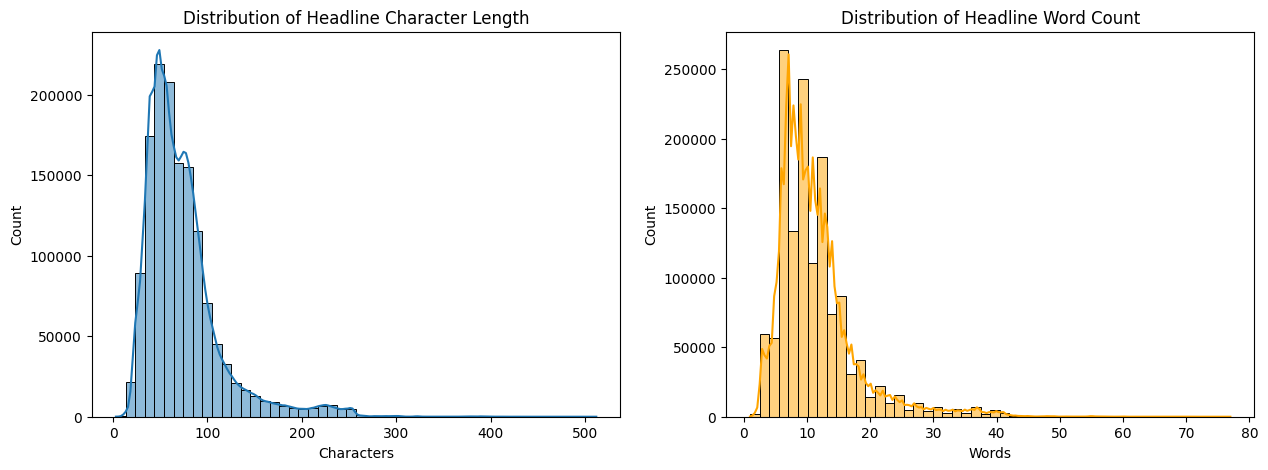

In [4]:
# 1. BASIC STATISTICS FOR TEXTUAL LENGTHES
df['headline_length'] = df['headline'].str.len()
df['word_count'] = df['headline'].str.split().str.len()

print("Text Length Statistics:")
print(df[['headline_length', 'word_count']].describe())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['headline_length'], bins=50, ax=ax1, kde=True)
ax1.set_title("Distribution of Headline Character Length")
ax1.set_xlabel("Characters")

sns.histplot(df['word_count'], bins=50, ax=ax2, kde=True, color='orange')
ax2.set_title("Distribution of Headline Word Count")
ax2.set_xlabel("Words")


Top 10 Publishers:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


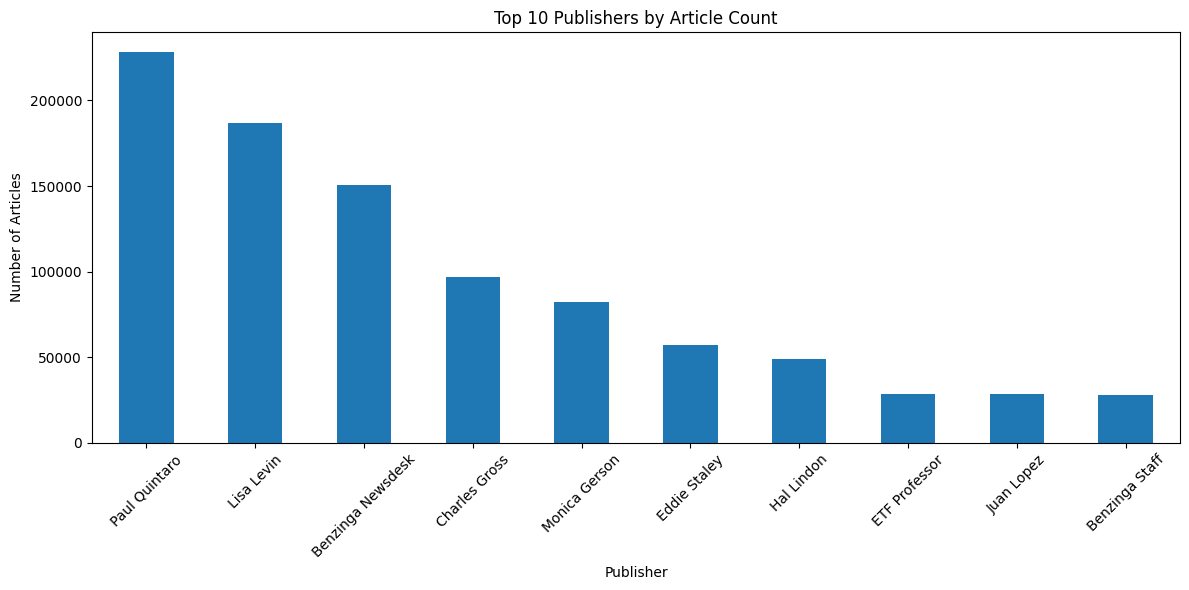

In [5]:
# 2. ARTICLES PER PUBLISHER
publisher_counts = df['publisher'].value_counts()
print("\nTop 10 Publishers:")
print(publisher_counts.head(10))

plt.figure(figsize=(12, 6))
publisher_counts.head(10).plot(kind='bar')
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../plots/publisher_distribution.png')
plt.show()

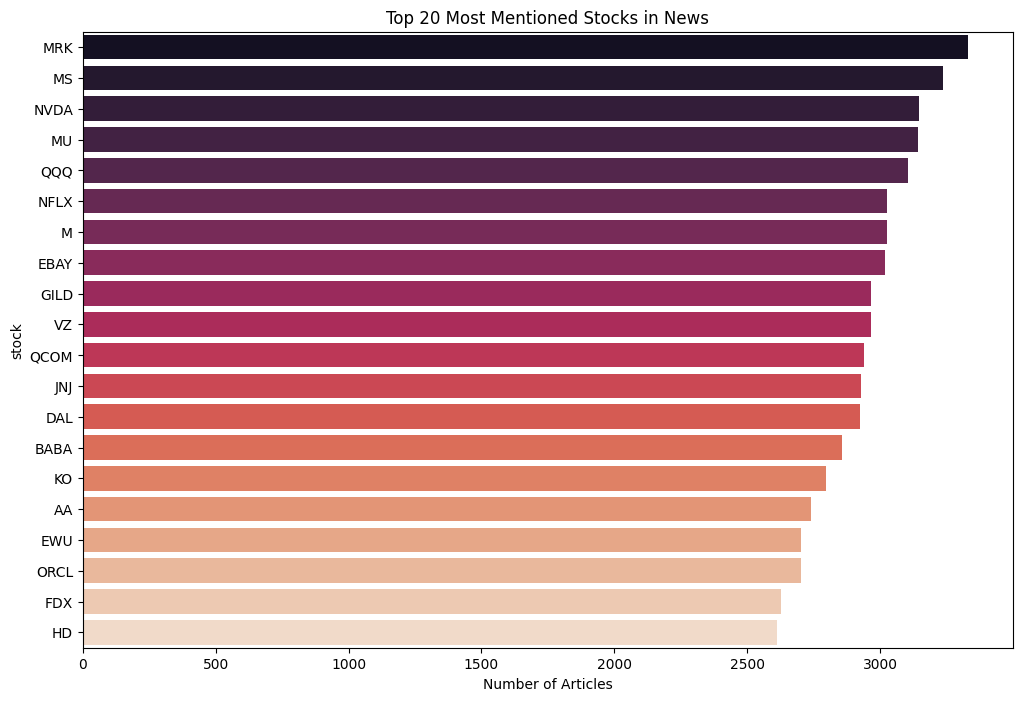

In [6]:
# 3. MOST COVERED STOCKS
top_stocks = df['stock'].value_counts().head(20)

top_stocks_df = top_stocks.reset_index()
top_stocks_df.columns = ['stock', 'count']

plt.figure(figsize=(12, 8))
sns.barplot(data=top_stocks_df, x='count', y='stock', hue='stock', dodge=False, palette='rocket', legend=False)
plt.title("Top 20 Most Mentioned Stocks in News")
plt.xlabel("Number of Articles")
plt.savefig('../plots/most_mentioned_stocks.png')
plt.show()

### Time Series Analysis

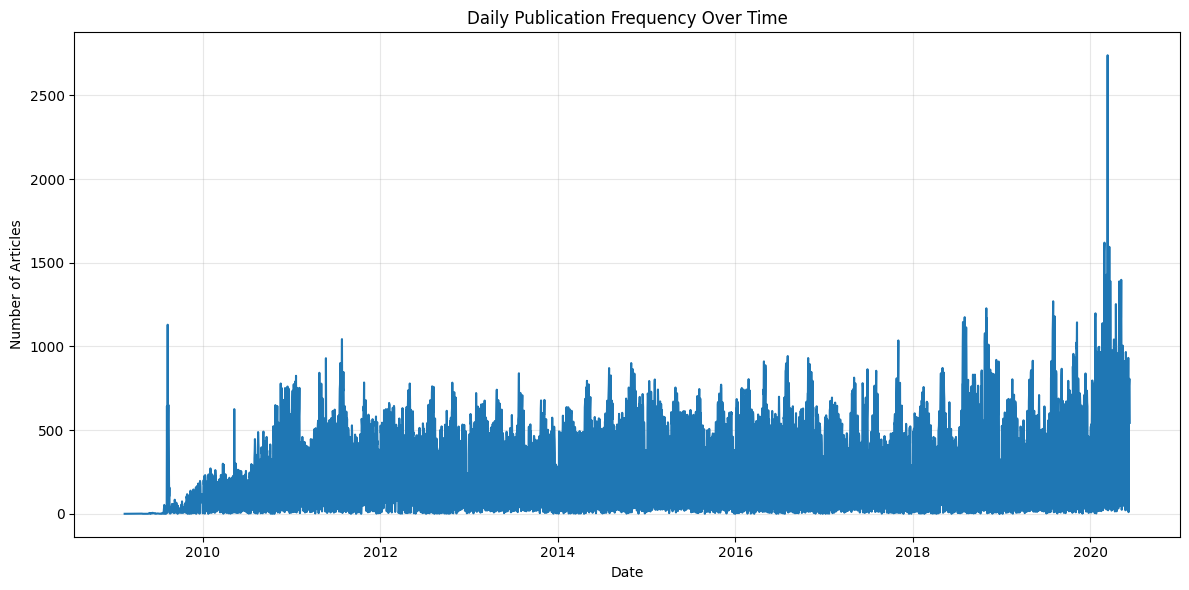

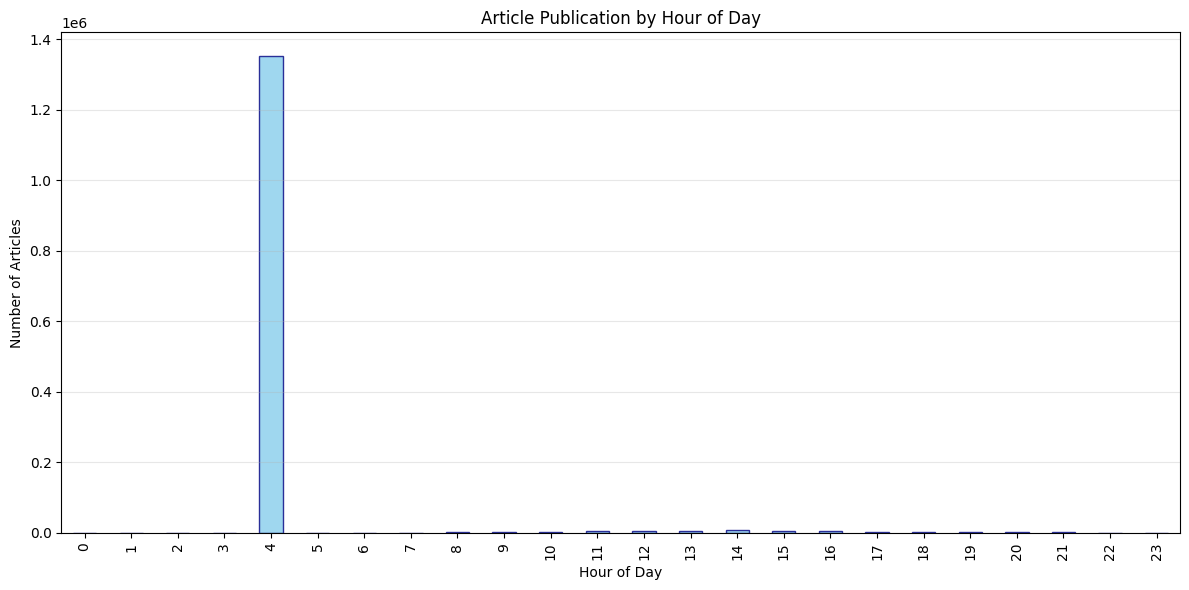

Peak news hour (UTC): 4 o'clock → 1351408 articles


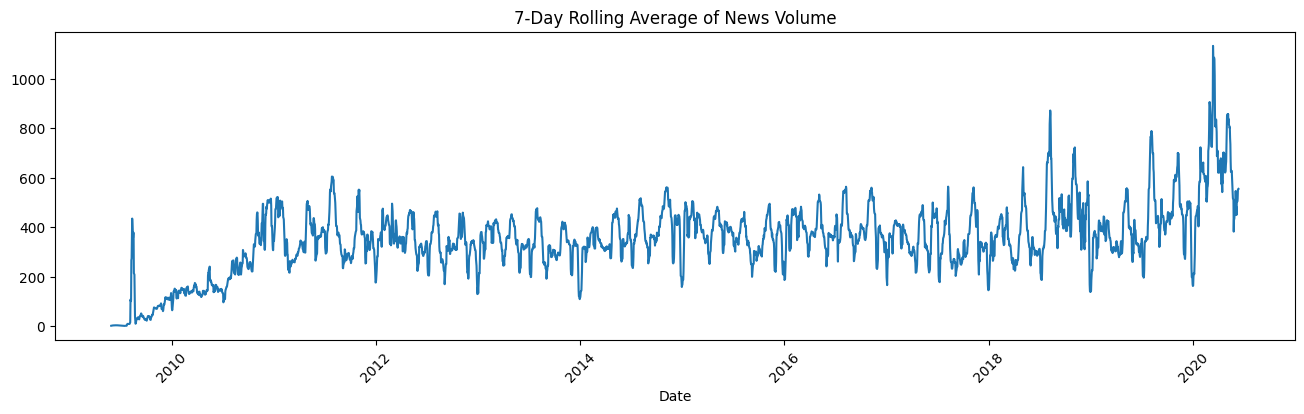

In [ ]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract date components
df['publication_date'] = df['date'].dt.date
df['publication_hour'] = df['date'].dt.hour
df['publication_day'] = df['date'].dt.day_name()

# 1. PUBLICATION FREQUENCY OVER TIME
daily_counts = df.groupby('publication_date').size()

plt.figure(figsize=(12, 6))
daily_counts.plot()
plt.title('Daily Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/daily_publication_frequency.png')
plt.show()

# 2. PUBLICATION BY HOUR
hourly_counts = df['publication_hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='bar', color='skyblue', edgecolor='navy', alpha=0.8)
plt.title('Article Publication by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/hourly_publication.png')
plt.show()
print("Peak news hour (UTC):", hourly_counts.idxmax(), "o'clock →", hourly_counts.max(), "articles")

# 3. ROLLING 7-DAY AVERAGE
daily_counts.rolling(7).mean().plot(figsize=(16, 4), title="7-Day Rolling Average of News Volume")
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

### Text Analysis

In [ ]:
# 1. NLP TO IDENTIFY COMMON KEYWORDS OR PHRASES
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Download the resources needed for word_tokenize and stopwords
nltk.download('punkt', quiet=False)
nltk.download('stopwords', quiet=False)
nltk.download('punkt_tab', quiet=False)

print("NLTK data downloaded successfully!")

# Additional financial stop words
financial_stopwords = {
    'inc', 'corp', 'ltd', 'co', 'llc', 'plc', 'shares', 'stock', 'said', 'say', 'says',
    'will', 'may', 'could', 'would', 'million', 'billion', 'quarter', 'year', 'month',
    'week', 'day', 'today', 'yesterday', 'monday', 'tuesday', 'wednesday', 'thursday',
    'friday', 'last', 'next', 'new', 'old', 'earnings', 'revenue', 'profit', 'loss'
}
stop_words = set(stopwords.words('english')).union(financial_stopwords)

# Clean and tokenize headline function
def clean_headline(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove numbers and symbols
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

# Apply cleaning
df['clean_headline'] = df['headline'].apply(clean_headline)

print("Sample cleaned headlines:")
for h in df['clean_headline'].head(5):
    print("→", h)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jakin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jakin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


NLTK data downloaded successfully!
Sample cleaned headlines:
→ stocks hit highs
→ stocks hit highs
→ biggest movers
→ stocks moving fridays midday session
→ securities maintains neutral agilent technologies raises price target


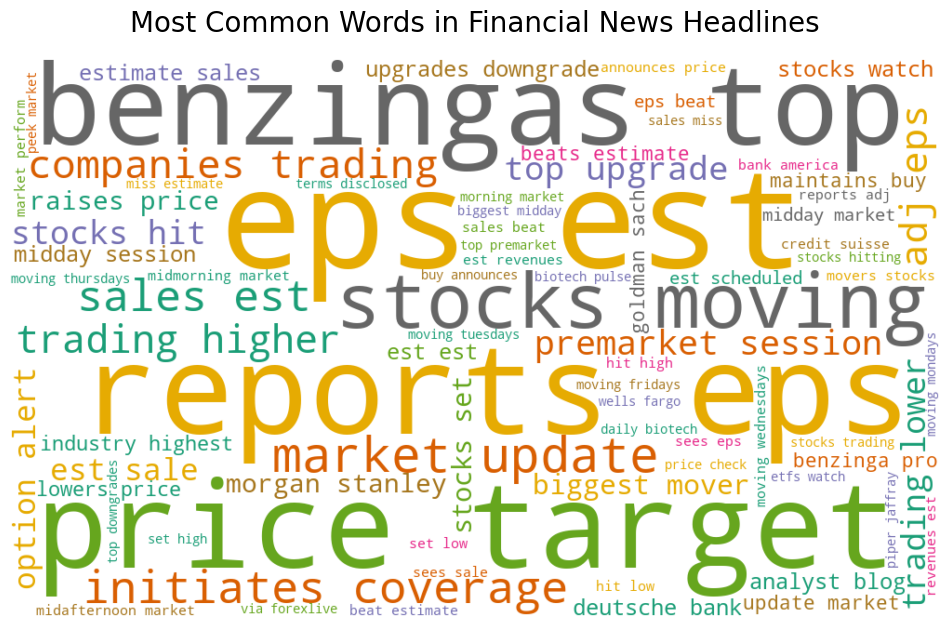

In [ ]:
# 2. WORD CLOUD TO SHOW MOST FREQUENT MEANINGFUL WORDS
all_text = ' '.join(df['clean_headline'])

wordcloud = WordCloud(
    width=1000, height=600,
    background_color='white',
    stopwords=stop_words,
    colormap='Dark2',
    contour_color='steelblue',
    contour_width=2,
    max_words=80,
    min_font_size=14,
    max_font_size=150,
    relative_scaling=0.6
).generate(all_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Financial News Headlines", fontsize=20, pad=20)
plt.savefig('../plots/most_common_words.png')
plt.show()

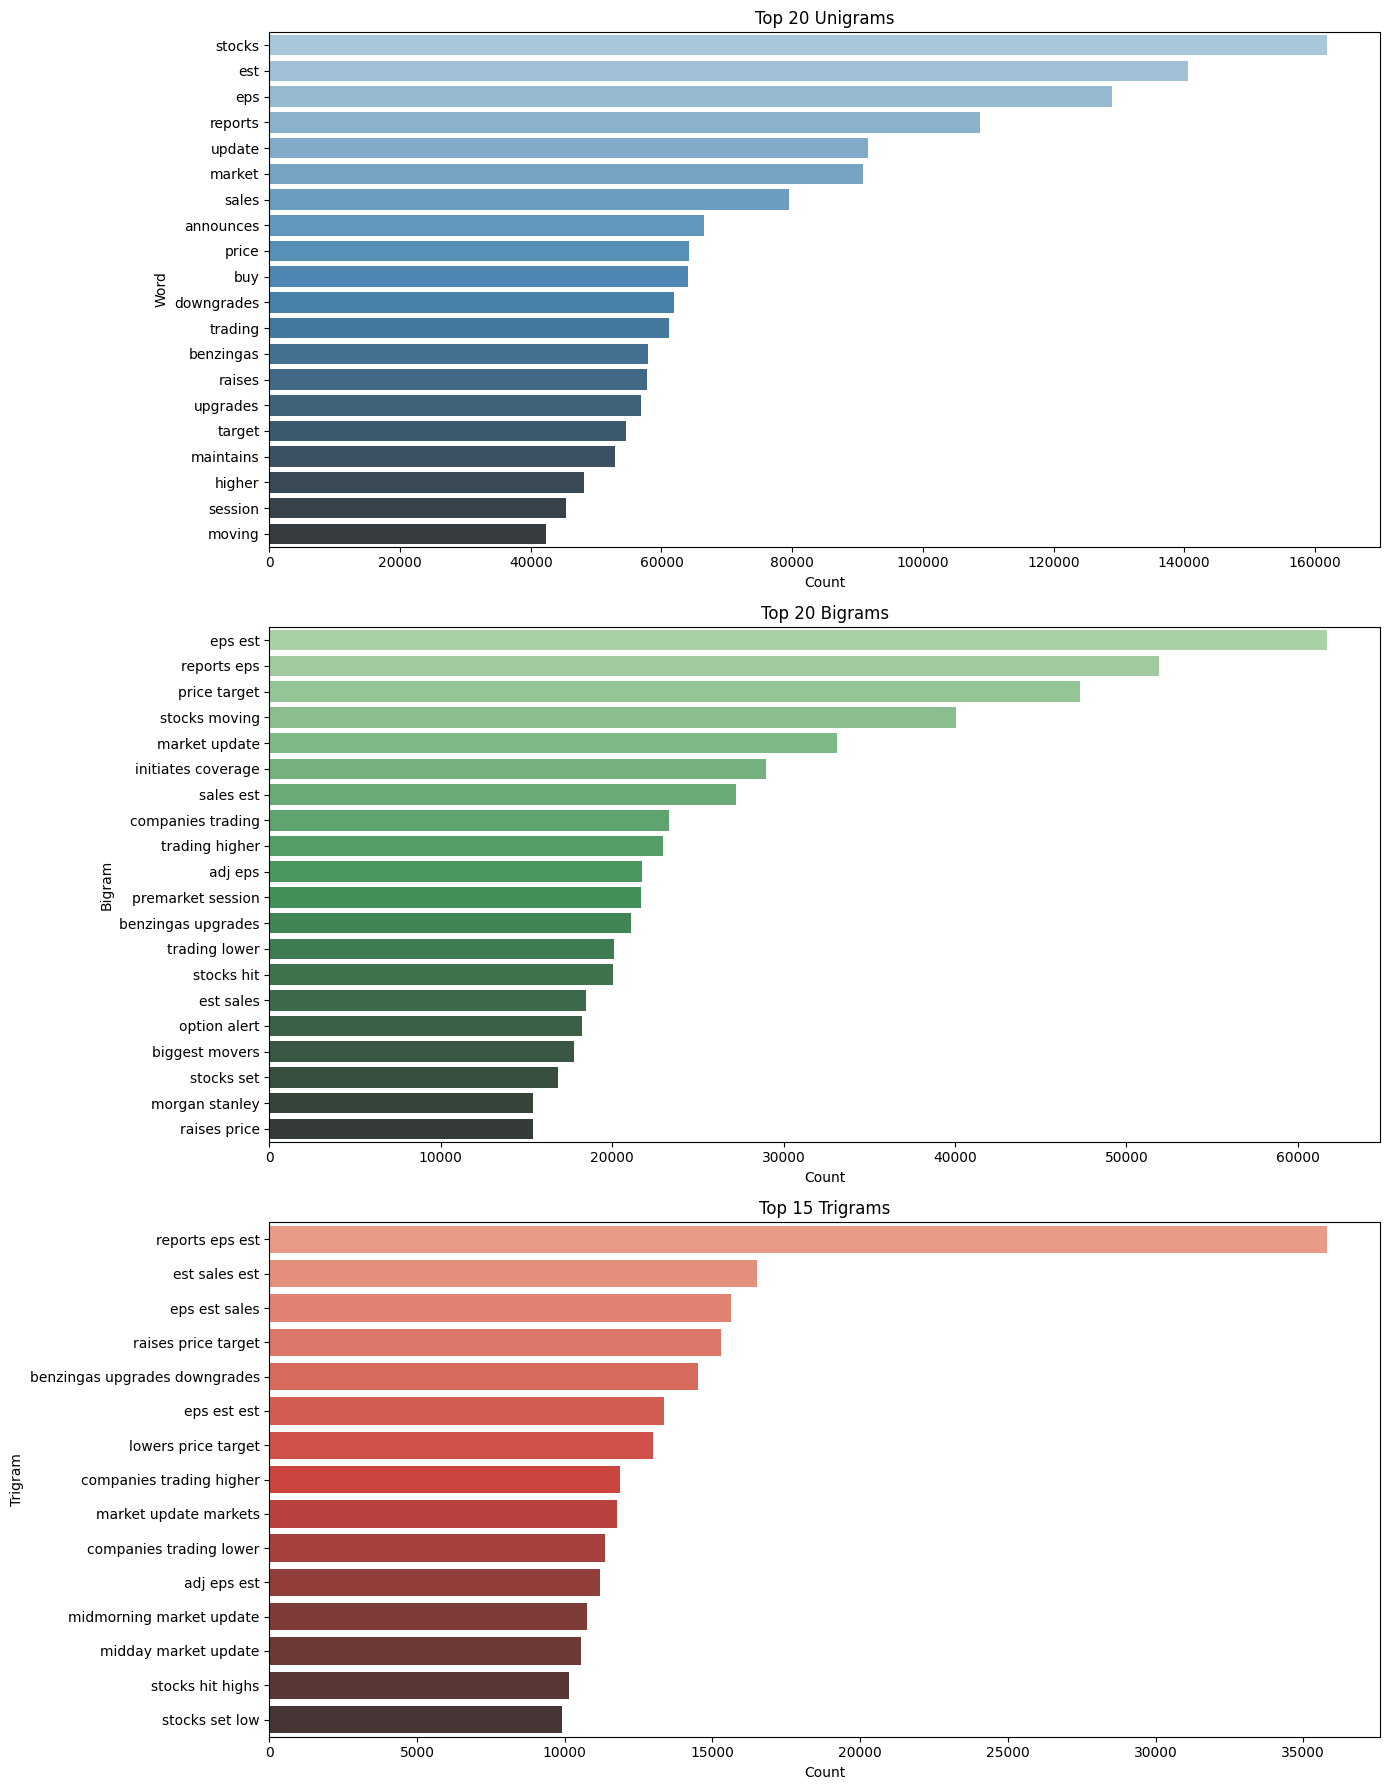


TOP FINANCIAL PHRASES DETECTED (BIGRAMS):
   • 'Eps est' – appears 61710 times
   • 'Reports eps' – appears 51917 times
   • 'Price target' – appears 47266 times
   • 'Stocks moving' – appears 40087 times
   • 'Market update' – appears 33089 times
   • 'Initiates coverage' – appears 28983 times
   • 'Sales est' – appears 27245 times
   • 'Companies trading' – appears 23313 times
   • 'Trading higher' – appears 22939 times
   • 'Adj eps' – appears 21711 times
   • 'Premarket session' – appears 21670 times
   • 'Benzingas upgrades' – appears 21115 times
   • 'Trading lower' – appears 20097 times
   • 'Stocks hit' – appears 20034 times
   • 'Est sales' – appears 18446 times


In [ ]:
# 3. TOP UNIGRAMS, BIGRAMS & TRIGRAMS
def get_top_ngrams(corpus, n=None, top_k=20):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Unigrams
top_unigrams = get_top_ngrams(df['clean_headline'], n=1, top_k=20)
uni_df = pd.DataFrame(top_unigrams, columns=['Word', 'Count'])

# Bigrams 
top_bigrams = get_top_ngrams(df['clean_headline'], n=2, top_k=20)
bi_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Count'])

# Trigrams
top_trigrams = get_top_ngrams(df['clean_headline'], n=3, top_k=15)
tri_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'Count'])

# Plot
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

sns.barplot(data=uni_df, y='Word', x='Count', ax=axes[0], hue='Word', dodge=False, palette='Blues_d')
if axes[0].get_legend(): axes[0].get_legend().remove()
axes[0].set_title("Top 20 Unigrams")

sns.barplot(data=bi_df, y='Bigram', x='Count', ax=axes[1], hue='Bigram', dodge=False, palette='Greens_d')
if axes[1].get_legend(): axes[1].get_legend().remove()
axes[1].set_title("Top 20 Bigrams")

sns.barplot(data=tri_df, y='Trigram', x='Count', ax=axes[2], hue='Trigram', dodge=False, palette='Reds_d')
if axes[2].get_legend(): axes[2].get_legend().remove()
axes[2].set_title("Top 15 Trigrams")

plt.tight_layout()
plt.show()

# Print top bigrams
print("\nTOP FINANCIAL PHRASES DETECTED (BIGRAMS):")
for phrase, count in top_bigrams[:15]:
    print(f"   • '{phrase.capitalize()}' – appears {count} times")

### Publisher Analysis

In [ ]:
# Analyze publisher patterns
publisher_stats = df.groupby('publisher').agg({
    'headline': 'count',
    'headline_length': 'mean',
    'word_count': 'mean'
}).rename(columns={
    'headline': 'article_count',
    'headline_length': 'avg_headline_length',
    'word_count': 'avg_word_count'
}).sort_values('article_count', ascending=False)

print("Publisher Statistics:")
print(publisher_stats.head(10))

# If publishers are email addresses, extract domains
if df['publisher'].str.contains('@').any():
    df['publisher_domain'] = df['publisher'].str.extract(r'@([\w.]+)')
    domain_counts = df['publisher_domain'].value_counts()
    print("\nTop Publisher Domains:")
    print(domain_counts.head(10))

Publisher Statistics:
                   article_count  avg_headline_length  avg_word_count
publisher                                                            
Paul Quintaro             228373            84.347839       13.195995
Lisa Levin                186979            47.502998        7.320715
Benzinga Newsdesk         150484           114.650508       17.805860
Charles Gross              96732            80.999328       12.783081
Monica Gerson              82380            51.002950        8.262078
Eddie Staley               57254            78.382296       11.848762
Hal Lindon                 49047            87.955064       13.252289
ETF Professor              28489            44.089438        7.933588
Juan Lopez                 28438            75.108200       11.738027
Benzinga Staff             28114            62.709789        9.359714

Top Publisher Domains:
publisher_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
inve